In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

from typing import Union, List
from diffSPH.kernels import getKernel
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import volumeToSupport

from diffSPH.v2.math import mod
from torchCompactRadius import radiusSearch
from torchCompactRadius.util import countUniqueEntries

from diffSPH.v2.sampling import sampleRegular
from torchCompactRadius import radiusSearch
from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import mod, volumeToSupport
from diffSPH.kernels import getKernel
from diffSPH.v2.neighborhood import neighborSearch
from diffSPH.v2.sampling import samplePDF
import numpy as np
import torch

from diffSPH.v2.finiteDifference import computeGradient
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None):
    sc = axis.scatter(p[:,0], p[:,1], s = 8, c = c)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    if p.shape[1] > 1:
        square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        axis.add_patch(square)
    axis.set_aspect('equal')
    axis.set_xlim(domainMin[0] * 1.05, domainMax[0] * 1.05)
    axis.set_ylim(domainMin[1] * 1.05, domainMax[1] * 1.05)

In [2]:
kernel = getKernel('Wendland4')

In [3]:
minExtent = -1
maxExtent = 1
nx = 16
dx = (maxExtent - minExtent) / nx
targetNeighbors = 50
k = getKernel('Wendland2')
periodic = True
dim = 2
volume = dx**dim
h = volumeToSupport(volume, targetNeighbors, dim)

# print(h)
# dx = dx / h
# minExtent = minExtent / h
# maxExtent = maxExtent / h
# volume = dx**dim
# print(volume)
# h = volumeToSupport(volume, targetNeighbors, dim)
# print(h)


domainMin = torch.tensor([minExtent]* dim, dtype = torch.float32)
domainMax = torch.tensor([maxExtent]* dim, dtype = torch.float32)

pInitial, volume = sampleRegular(dx, dim, minExtent, domainMax, targetNeighbors, True, k)


In [4]:
p = pInitial + torch.normal(0, 0.05 * h, pInitial.shape)
p = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
    
# p = torch.clone(pInitial)

In [5]:

areas = p.new_ones(p.shape[0]) * volume
ones = p.new_ones(p.shape[0])
supports = p.new_ones(p.shape[0]) * h


i, j, rij, xij, hij, Wij, gradWij = neighborSearch(p, p, h, h, kernel = k, dim = dim, periodic = periodic, minDomain = domainMin, maxDomain = domainMax)
ii, ni = countUniqueEntries(i, p)

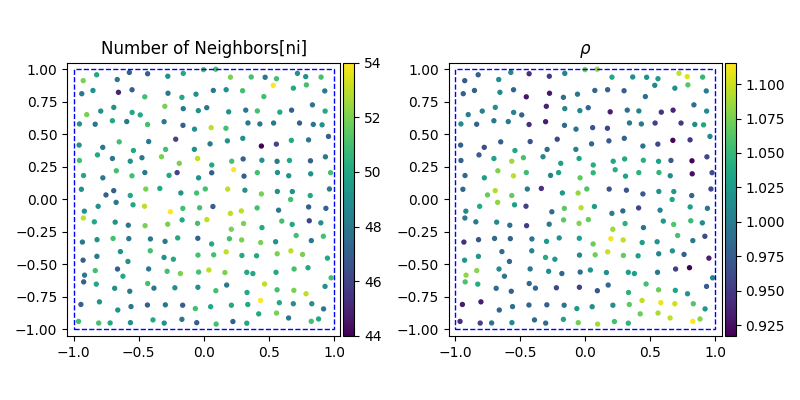

In [6]:
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)


scatterPlot(fig, axis[0,0], p, ni, domainMin, domainMax, 'Number of Neighbors[ni]')
rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')

scatterPlot(fig, axis[0,1], p, rho, domainMin, domainMax, '$\\rho$')

fig.tight_layout()

torch.Size([256, 256, 2])
torch.Size([256, 256]) torch.Size([256, 256]) torch.Size([256, 256]) 2 0.49867785050179086


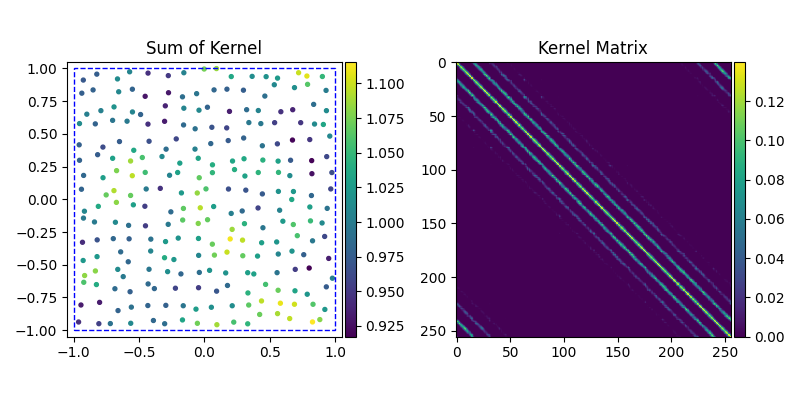

In [7]:
pos = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
x_ij = p[:,None] - p[None,:]
x_ij = pos[None,:] - pos[:,None]
x_ij[:,:,0] = x_ij[:,:,0] if not periodic else mod(x_ij[:,:,0], domainMin[0], domainMax[0])
x_ij[:,:,1] = x_ij[:,:,1] if not periodic else mod(x_ij[:,:,1], domainMin[1], domainMax[1])
r_ij = torch.norm(x_ij, dim = -1)
q_ij = torch.where(r_ij < h, r_ij, h) /h
# denseDistance = denseDistance / (denseRadialDistance[:,:,None] + 1e-4 * h)

supportMatrix = p.new_ones(p.shape[0], p.shape[0]) * h
print(x_ij.shape)


denseKernel = p.new_zeros(p.shape[0], p.shape[0])

print(denseKernel.shape, supportMatrix.shape, q_ij.shape, dim, h)
denseKernel = volume * k.kernel(q_ij, supportMatrix, dim = dim)#.reshape(p.shape[0], p.shape[0])
# denseKernel[q_ij >= 1] = 0

fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], p, denseKernel.sum(-1), domainMin, domainMax, 'Sum of Kernel')

im = axis[0,1].imshow(denseKernel, cmap = 'viridis')
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cb = fig.colorbar(im, cax=cax1,orientation='vertical')
axis[0,1].set_title('Kernel Matrix')
axis[0,1].set_aspect('equal')


fig.tight_layout()

In [8]:
denseKernel.sum(-1)

tensor([0.9443, 0.9551, 0.9909, 1.0096, 0.9834, 0.9884, 1.0331, 1.0725, 1.0882,
        1.0569, 1.0470, 1.0700, 1.0895, 1.0964, 1.1156, 1.0799, 0.9313, 0.9322,
        0.9794, 0.9904, 0.9807, 0.9777, 0.9941, 1.0258, 1.0152, 1.0137, 1.0652,
        1.0959, 1.1087, 1.1014, 1.0614, 1.0220, 1.0593, 1.0385, 0.9855, 0.9772,
        0.9853, 0.9823, 0.9577, 0.9523, 0.9706, 0.9847, 1.0440, 1.0560, 1.0700,
        1.0326, 1.0204, 0.9739, 1.0820, 1.0800, 1.0119, 0.9977, 0.9947, 1.0147,
        0.9816, 0.9883, 1.0190, 1.0181, 1.0283, 1.0302, 0.9934, 0.9528, 0.9173,
        1.0040, 1.0233, 1.0229, 0.9855, 0.9828, 1.0072, 1.0386, 1.0220, 1.0082,
        1.0723, 1.0990, 1.0678, 1.0281, 1.0077, 1.0198, 0.9776, 0.9341, 0.9420,
        0.9681, 0.9835, 0.9774, 0.9918, 1.0237, 1.0192, 1.0294, 1.0692, 1.1124,
        1.0954, 1.0282, 1.0207, 1.0577, 0.9970, 0.9610, 0.9980, 0.9985, 1.0106,
        0.9899, 0.9523, 0.9971, 1.0646, 1.0782, 1.0681, 1.0859, 1.0437, 0.9952,
        1.0247, 1.0606, 1.0506, 1.0110, 

In [9]:
def imPlot(fig, axis, data, label = None):
    im = axis.imshow(data, cmap = 'viridis')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(im, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    axis.set_aspect('equal')

Given a kernel:
$$ W(x_i - x_j, y_i - y_j, h) = C_d h^{-d} f\left(\frac{\sqrt{\left(x_i - x_j\right)^2 + \left(y_i -y_j\right)^2}}{h}\right)$$

For convenience denote $q_{ij} = \frac{\sqrt{\left(x_i - x_j\right)^2 + \left(y_i -y_j\right)^2}}{h}$ and $r_{ij} = \sqrt{\left(x_i - x_j\right)^2 + \left(y_i -y_j\right)^2}$

We need the first derivatives w.r.t. x_j and y_j, i.e., $ \frac{\partial W}{\partial x_j}$ and $\frac{\partial W}{\partial y_j}$. Using [Wolfram](https://www.wolframalpha.com/input?i=d%2Fdx+f%28%5Csqrt%28%28a-x%29%5E2+%2B+%28b-y%29%5E2%29%2Fh%29) we get:

$$ \frac{\partial W}{\partial x_j} = \frac{x_i - x_j}{r_{ij}} C_d h^{-(d+1)} f^\prime(q_{ij}) $$
and
$$ \frac{\partial W}{\partial x_j} = \frac{y_i - y_j}{r_{ij}} C_d h^{-(d+1)} f^\prime(q_{ij}) $$



For the second derivatives we get more complex terms for $\frac{\partial^2}{\partial x^2}$ ([Wolfram](https://www.wolframalpha.com/input?i=d%5E2%2F%28dx%5E2%29+f%28%5Csqrt%28%28a-x%29%5E2+%2B+%28b-y%29%5E2%29%2Fh%29)):

$$ \frac{\partial^2}{\partial x^2} W = C_d h^{-d} \cdot \left[
    \frac{\left(x_i - x_j\right)^2}{h^2 r_{ij}^2} f^{\prime\prime}(q_{ij}) +\left(\frac{1}{h r_{ij}} - \frac{\left(x_i - x_j\right)^2}{h r_{ij}^{3}}\right)f^\prime(q_{ij}) \right]
$$



And for the diagonal terms: [Wolfram](https://www.wolframalpha.com/input?i=d%5E2%2F%28dxdy%29+f%28%5Csqrt%28%28a-x%29%5E2+%2B+%28b-y%29%5E2%29%2Fh%29):

$$\frac{\partial^2}{\partial x\partial y} W = C_d h^{-d} \frac{\left(x_i - x_j\right)\left(y_i - y_j\right)}{h r_{ij}^2} \cdot \left[ \frac{1}{h} f^{\prime\prime}(q_{ij}) - \frac{1}{r_{ij}} f^\prime(q_{ij})\right]$$

In [10]:
dim = 2
def Jacobian(x_ij, r_ij, q_ij, h, k):
    jacobian = torch.zeros(x_ij.shape[0], x_ij.shape[0], 2)
    dWdx = x_ij[:,:,0] / (r_ij + 1e-7 * h) * k.dkdq(q_ij, dim = dim) * k.C_d(dim) / h**(dim + 1)
    dWdy = x_ij[:,:,1] / (r_ij + 1e-7 * h) * k.dkdq(q_ij, dim = dim) * k.C_d(dim) / h**(dim + 1)
    jacobian[:,:,0] = torch.where(q_ij <= 1, dWdx, 0)
    jacobian[:,:,1] = torch.where(q_ij <= 1, dWdy, 0)
    return jacobian

def Hessian(x_ij, r_ij, q_ij, h, k):
    hessian = torch.zeros(x_ij.shape[0], x_ij.shape[0], 2, 2)

    factor = k.C_d(dim) * h**(-dim)

    termA_x = x_ij[:,:,0]**2 / (h * r_ij    + 1e-5 * h)**2 * k.d2kdq2(q_ij, dim = dim)
    termA_y = x_ij[:,:,1]**2 / (h * r_ij    + 1e-5 * h)**2 * k.d2kdq2(q_ij, dim = dim)

    termB_x = torch.where(r_ij / h > 1e-5, 1 /(h * r_ij + 1e-6 * h),0) * k.dkdq(q_ij, dim = dim)
    termB_y = torch.where(r_ij / h > 1e-5, 1 /(h * r_ij + 1e-6 * h),0) * k.dkdq(q_ij, dim = dim)

    termC_x = - (x_ij[:,:,0]**2) / (h * r_ij**3 + 1e-5 * h) * k.dkdq(q_ij, dim = dim)
    termC_y = - (x_ij[:,:,1]**2) / (h * r_ij**3 + 1e-5 * h) * k.dkdq(q_ij, dim = dim)
               
    d2Wdx2 = factor * (termA_x + termB_x + termC_x)
    d2Wdy2 = factor * (termA_y + termB_y + termC_y)

    manualLaplacian =\
        ((torch.where(q_ij > -1e-7, ((dim - 1) / (q_ij *h + 1e-7 * h)) * k.dkdq(q_ij + 1e-7, dim) * h, 0) + k.d2kdq2(q_ij, dim)) * k.C_d(dim)) / h**(dim + 2)

    laplacian = d2Wdx2 + d2Wdy2

    d2Wdxy = k.C_d(dim) * h**(-dim) * torch.where(q_ij > -1e-7, \
        ( x_ij[:,:,0] * x_ij[:,:,1]) / (h * r_ij **2 + 1e-5 * h) * (1 / h * k.d2kdq2(q_ij, dim = dim) - 1 / (r_ij + 1e-3 * h) * k.dkdq(q_ij, dim = dim)),0)
    d2Wdyx = d2Wdxy

    hessian[:,:,0,0] = torch.where(torch.logical_and(q_ij <= 1, q_ij>1e-5), d2Wdx2, 0)
    hessian[:,:,1,1] = torch.where(torch.logical_and(q_ij <= 1, q_ij>1e-5), d2Wdy2, 0)
    hessian[:,:,0,1] = torch.where(torch.logical_and(q_ij <= 1, q_ij>1e-5), d2Wdxy, 0)
    hessian[:,:,1,0] = torch.where(torch.logical_and(q_ij <= 1, q_ij>1e-5), d2Wdyx, 0)


    # df[:,0,0] = 20 * c / h**7 * (l - h)**3
    
    # df[l>0,0,0] -= (60 * c / h**7 * (l-h)**2 * dx * -dx)[l>0] / l[l>0]
    
    # df[l>0,0,1] = - (60 * c / h**7 * -dx*dy * (l - h)**2)[l>0] / l[l>0]
    # df[:,1,0] = df[:,0,1]
    
    # df[:,1,1] = 20 * c / h**7 * (l - h)**3
    # df[l>0,1,1] -= (60 * c / h**7 * (l-h)**2 * -dy * dy)[l>0] / l[l>0]
    
    # df[q>1,:,:] = 0.

    return hessian, manualLaplacian

In [11]:
# def firstDerivative(config, state, reduce = True):
#     d = -state['fluidDistances']
#     r =  state['fluidRadialDistances']
    
#     neighbors = state['fluidNeighbors']
# #     print(neighbors.shape)
#     i = neighbors[1]
#     j = neighbors[0]
    
#     support = config['support']
    
#     a = state['fluidPosition'][i]
#     b = state['fluidPosition'][j]
    
#     df = d.flatten().reshape(d.shape[0] * d.shape[1])
#     rf = r.flatten()
#     qf = rf / support
    
#     x_a = a[:,0]
#     x = b[:,0]
#     y_a = a[:,1]
#     y = b[:,1]
    
#     l = torch.sqrt((x_a - x)**2 + (y_a - y)**2).flatten()
#     q = l / support
#     dx = (x_a - x).flatten()
#     dy = (y_a - y).flatten()
    
#     df = torch.zeros((dx.shape[0],2), dtype=dx.dtype, device = dx.device)
# #     print(a)
# #     print('x_a', x_a.shape)
# #     print('x', x.shape)
# #     print('dx', dx.shape)
# #     print('dy', dy.shape)
# #     print('l', l.shape)
# #     print('df',df.shape)

#     c = 7. / np.pi
#     h = support
    
#     df[:,0] = -(20 * c * (h **(-7))* (dx) *pow(l -h, 3)).flatten()
#     df[:,1] = -(20 * c * (h **(-7))* (dy) *pow(l -h, 3)).flatten()
    
#     df[q>1,0] = 0
#     df[q>1,1] = 0
#     if reduce:
#         df = scatter_sum(df, i, dim = 0, dim_size = state['numParticles'])
#         # syncQuantity(df, config, state)

#         return df
#     return df

# manualJ = firstDerivative({'support': h}, {'fluidDistances': xij, 'fluidRadialDistances': rij, 'fluidNeighbors': (i,j), 'fluidPosition': p, 'numParticles': p.shape[0]}, reduce = True)
    

In [12]:
# J = Jacobian(x_ij, r_ij, q_ij, h, k).sum(1)

# diff = J - manualJ
# print(f'Jacobian Difference: {diff.abs().max()}')
# # print(J - manualJ)

# fig, axis = plt.subplots(2, 3, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
# scatterPlot(fig, axis[0,0], p, J[:,0], domainMin, domainMax, 'Jacobian x')
# scatterPlot(fig, axis[1,0], p, J[:,1], domainMin, domainMax, 'Jacobian y')
# scatterPlot(fig, axis[0,1], p, manualJ[:,0], domainMin, domainMax, 'Manual Jacobian x')
# scatterPlot(fig, axis[1,1], p, manualJ[:,1], domainMin, domainMax, 'Manual Jacobian y')
# scatterPlot(fig, axis[0,2], p, diff[:,0], domainMin, domainMax, 'Difference x')
# scatterPlot(fig, axis[1,2], p, diff[:,1], domainMin, domainMax, 'Difference y')

# fig.tight_layout()

In [13]:
# def secondDerivative(config, state, reduce = True):
#     d = -state['fluidDistances']
#     r =  state['fluidRadialDistances']
    
#     neighbors = state['fluidNeighbors']
#     support = config['support']
# #     print(neighbors.shape)
#     i = neighbors[1]
#     j = neighbors[0]
    
#     a = state['fluidPosition'][i]
#     b = state['fluidPosition'][j]
    
#     df = d.flatten().reshape(d.shape[0] * d.shape[1])
#     rf = r.flatten()
#     qf = rf / support
    
#     x_a = a[:,0]
#     x = b[:,0]
#     y_a = a[:,1]
#     y = b[:,1]
    
    
# #     df[:,0,0] = 1.
    
#     c = 7. / np.pi
#     h = support
    
#     l = torch.sqrt((x_a - x)**2 + (y_a - y)**2).flatten()
#     q = l / support
#     dx = (x_a - x).flatten()
#     dy = (y_a - y).flatten()
    
#     df = torch.zeros((dx.shape[0],2,2), device = dx.device, dtype=dx.dtype)
    
    
#     df[:,0,0] = 20 * c / h**7 * (l - h)**3
    
#     df[l>0,0,0] -= (60 * c / h**7 * (l-h)**2 * dx * -dx)[l>0] / l[l>0]
    
#     df[l>0,0,1] = - (60 * c / h**7 * -dx*dy * (l - h)**2)[l>0] / l[l>0]
#     df[:,1,0] = df[:,0,1]
    
#     df[:,1,1] = 20 * c / h**7 * (l - h)**3
#     df[l>0,1,1] -= (60 * c / h**7 * (l-h)**2 * -dy * dy)[l>0] / l[l>0]
    
#     df[q>1,:,:] = 0.
    
#     if reduce:
#         df = scatter_sum(df, i, dim = 0, dim_size = state['numParticles'])
#         # syncQuantity(df, config, state)

#         return df
#     return df

# manualH = secondDerivative({'support': h}, {'fluidDistances': xij, 'fluidRadialDistances': rij, 'fluidNeighbors': (i,j), 'fluidPosition': p, 'numParticles': p.shape[0]}, reduce = False)
# H = Hessian(x_ij, r_ij, q_ij, h, k)[0]

In [14]:
dim = 2
def Jacobian(x_ij, r_ij, q_ij, h, k):
    jacobian = torch.zeros(x_ij.shape[0], x_ij.shape[0], 2)
    dWdx = x_ij[:,:,0] / (r_ij + 1e-7 * h) * k.dkdq(q_ij, dim = dim) * k.C_d(dim) / h**(dim + 1)
    dWdy = x_ij[:,:,1] / (r_ij + 1e-7 * h) * k.dkdq(q_ij, dim = dim) * k.C_d(dim) / h**(dim + 1)
    jacobian[:,:,0] = torch.where(q_ij <= 1, dWdx, 0)
    jacobian[:,:,1] = torch.where(q_ij <= 1, dWdy, 0)
    return jacobian

def Hessian(x_ij, r_ij, q_ij, h, k):
    hessian = torch.zeros(x_ij.shape[0], x_ij.shape[0], 2, 2)

    factor = k.C_d(dim) * h**(-dim)

    termA_x = x_ij[:,:,0]**2 / (h * r_ij    + 1e-5 * h)**2 * k.d2kdq2(q_ij, dim = dim)
    termA_y = x_ij[:,:,1]**2 / (h * r_ij    + 1e-5 * h)**2 * k.d2kdq2(q_ij, dim = dim)

    termB_x = torch.where(r_ij / h > 1e-5, 1 /(h * r_ij + 1e-6 * h),0) * k.dkdq(q_ij, dim = dim)
    termB_y = torch.where(r_ij / h > 1e-5, 1 /(h * r_ij + 1e-6 * h),0) * k.dkdq(q_ij, dim = dim)

    termC_x = - (x_ij[:,:,0]**2) / (h * r_ij**3 + 1e-5 * h) * k.dkdq(q_ij, dim = dim)
    termC_y = - (x_ij[:,:,1]**2) / (h * r_ij**3 + 1e-5 * h) * k.dkdq(q_ij, dim = dim)
               
    # d2Wdx2 = factor * (termA_x + termB_x + termC_x + torch.where(q_ij < 1e-5, k.d2kdq2(torch.tensor(0.), dim = dim), 0))
    # d2Wdy2 = factor * (termA_y + termB_y + termC_y)
    
    d2Wdx2 = factor * (termA_x + termB_x + termC_x + 1/h**2 * torch.where(q_ij < 1e-5, k.d2kdq2(torch.tensor(0.), dim = dim), 0))
    d2Wdy2 = factor * (termA_y + termB_y + termC_y + 1/h**2 * torch.where(q_ij < 1e-5, k.d2kdq2(torch.tensor(0.), dim = dim), 0))

    manualLaplacian =\
        ((torch.where(q_ij > -1e-7, ((dim - 1) / (q_ij *h + 1e-7 * h)) * k.dkdq(q_ij + 1e-7, dim) * h, 0) + k.d2kdq2(q_ij, dim)) * k.C_d(dim)) / h**(dim + 2)

    laplacian = d2Wdx2 + d2Wdy2

    d2Wdxy = k.C_d(dim) * h**(-dim) * torch.where(q_ij > -1e-7, \
        ( x_ij[:,:,0] * x_ij[:,:,1]) / (h * r_ij **2 + 1e-5 * h) * (1 / h * k.d2kdq2(q_ij, dim = dim) - 1 / (r_ij + 1e-3 * h) * k.dkdq(q_ij, dim = dim)),0)
    d2Wdyx = d2Wdxy

    hessian[:,:,0,0] = torch.where(q_ij <= 1, d2Wdx2, 0)
    hessian[:,:,1,1] = torch.where(q_ij <= 1, d2Wdy2, 0)
    hessian[:,:,0,1] = torch.where(q_ij <= 1, d2Wdxy, 0)
    hessian[:,:,1,0] = torch.where(q_ij <= 1, d2Wdyx, 0)


    # df[:,0,0] = 20 * c / h**7 * (l - h)**3
    
    # df[l>0,0,0] -= (60 * c / h**7 * (l-h)**2 * dx * -dx)[l>0] / l[l>0]
    
    # df[l>0,0,1] = - (60 * c / h**7 * -dx*dy * (l - h)**2)[l>0] / l[l>0]
    # df[:,1,0] = df[:,0,1]
    
    # df[:,1,1] = 20 * c / h**7 * (l - h)**3
    # df[l>0,1,1] -= (60 * c / h**7 * (l-h)**2 * -dy * dy)[l>0] / l[l>0]
    
    # df[q>1,:,:] = 0.

    return hessian, manualLaplacian

H = Hessian(x_ij, r_ij, q_ij, h, k)[0]

# diff = H - manualH
# print(f'Hessian Difference xx: {diff[:,0,0].abs().max()}')
# print(f'Hessian Difference xy: {diff[:,0,1].abs().max()}')
# print(f'Hessian Difference yx: {diff[:,1,0].abs().max()}')
# print(f'Hessian Difference yy: {diff[:,1,1].abs().max()}')

In [16]:
H.shape

print(x_ij.flatten(0,1).shape)
print(r_ij.flatten(0,1).shape)

# print(x_ij[:,0])

H_direct = k.Hessian2D(r_ij.flatten(0,1) / h, (x_ij.flatten(0,1) / (r_ij.flatten(0,1) + 1e-5 * h).view(-1,1)), h, dim = 2)

# H_direct = k.Hessian2D(r_ij / h, x_ij / (r_ij + 1e-5 * h).view(r_ij.shape[0], r_ij.shape[1],1), h, dim = 2)

H_direct = H_direct.reshape(p.shape[0], p.shape[0], 2, 2)

print((H_direct - H).max())

torch.Size([65536, 2])
torch.Size([65536])
tensor(0.0157)


In [377]:
offsets = j[i==0]
sortIndex = torch.argsort(offsets)
offsets.numpy().tolist().index(32)
print(sortIndex)

tensor([43, 34, 47, 46, 13, 14, 15, 12, 41, 40, 39, 38, 16, 17, 18, 19, 35, 36,
        37, 42, 11, 21, 20, 44, 45, 10,  9, 33,  6, 28, 27, 26,  8,  7, 22, 23,
        24, 25,  5,  4,  3, 29, 30, 31, 32,  1,  2,  0])


In [378]:
manualH[i == 0]
H[0,:][q_ij[0,:] < 1]

print(manualH[i == 0].shape)
# print(i)
for ci in range(manualH[i==0].shape[0]):
    print(f'Particle {ci}')
    print(f'Manual Hessian: {manualH[i == 0][sortIndex[ci]]}')
    print(f'Computed Hessian: {H[0][q_ij[0,:] < 1][ci]}')
    print(f'Difference: {manualH[i == 0][sortIndex[ci]] - H[0][q_ij[0,:] < 1][ci]}')
    print(f'Difference (Factor): {manualH[i == 0][sortIndex[ci]] / H[0][q_ij[0,:] < 1][ci]}')

    # if ci > 2:
        # break
    # 

torch.Size([48, 2, 2])
Particle 0
Manual Hessian: tensor([[-720.6060,    0.0000],
        [   0.0000, -720.6060]])
Computed Hessian: tensor([[-720.6060,   -0.0000],
        [  -0.0000, -720.6060]])
Difference: tensor([[0., 0.],
        [0., 0.]])
Difference (Factor): tensor([[1., nan],
        [nan, 1.]])
Particle 1
Manual Hessian: tensor([[ 115.8900,   33.5564],
        [  33.5564, -196.8455]])
Computed Hessian: tensor([[ 115.4967,   33.4848],
        [  33.4848, -196.8488]])
Difference: tensor([[0.3933, 0.0715],
        [0.0715, 0.0033]])
Difference (Factor): tensor([[1.0034, 1.0021],
        [1.0021, 1.0000]])
Particle 2
Manual Hessian: tensor([[158.8113,  65.3630],
        [ 65.3630, -53.0328]])
Computed Hessian: tensor([[158.7648,  65.3190],
        [ 65.3190, -53.0363]])
Difference: tensor([[0.0465, 0.0441],
        [0.0441, 0.0035]])
Difference (Factor): tensor([[1.0003, 1.0007],
        [1.0007, 0.9999]])
Particle 3
Manual Hessian: tensor([[45.5995,  0.4819],
        [ 0.4819, 

In [379]:
selfManual = manualH[i == 0][sortIndex[0]]
selfNew = H[0][q_ij[0,:] < 1][0]

print(f'Self Manual Hessian: {selfManual}')
print(f'Self Computed Hessian: {selfNew}')
print(f'Self Difference: {selfManual - selfNew}')
print(f'Self Difference (Factor): {selfManual / selfNew}')

fac = selfManual[0,0] / selfNew[0,0]
print(fac)

Self Manual Hessian: tensor([[-720.6060,    0.0000],
        [   0.0000, -720.6060]])
Self Computed Hessian: tensor([[-720.6060,   -0.0000],
        [  -0.0000, -720.6060]])
Self Difference: tensor([[0., 0.],
        [0., 0.]])
Self Difference (Factor): tensor([[1., nan],
        [nan, 1.]])
tensor(1.)


In [380]:
print(1/h**2)

4.021238596594935


In [381]:
H = Hessian(x_ij, r_ij, q_ij, h, k)[0].sum(1)
manualH = secondDerivative({'support': h}, {'fluidDistances': xij, 'fluidRadialDistances': rij, 'fluidNeighbors': (i,j), 'fluidPosition': p, 'numParticles': p.shape[0]}, reduce = True)

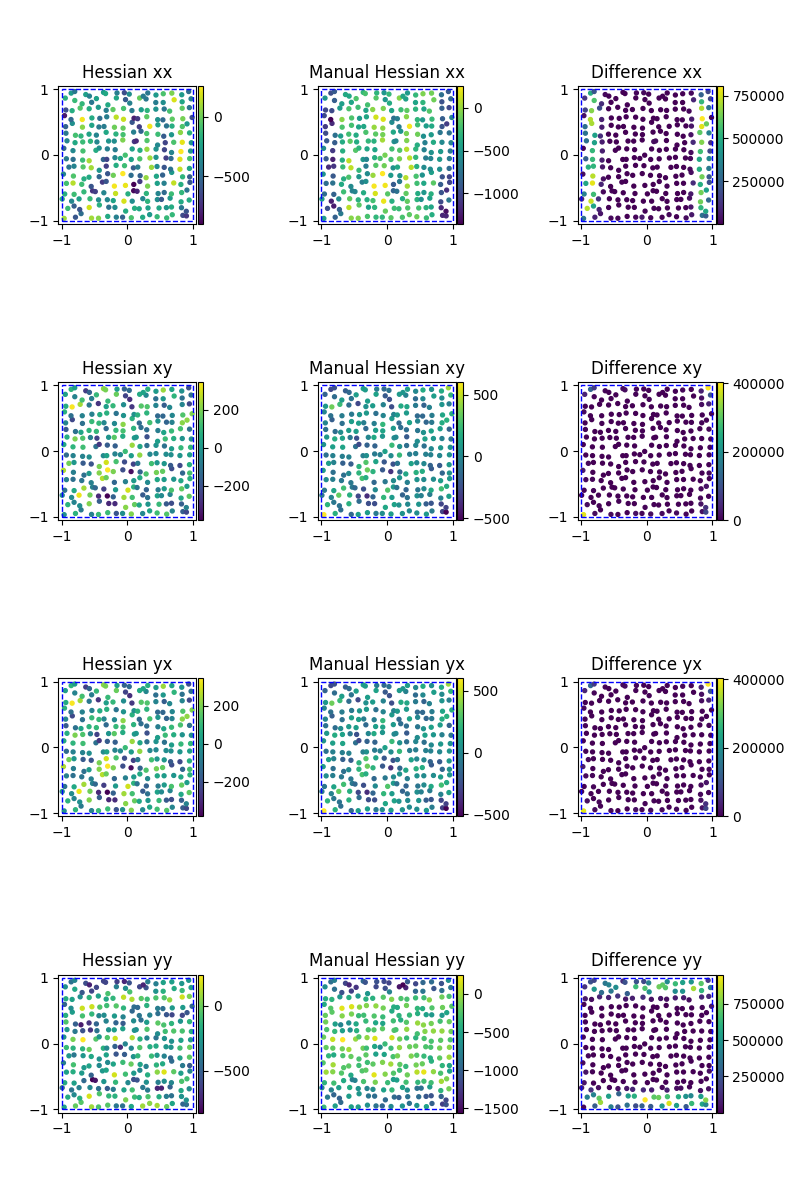

In [382]:
fig, axis = plt.subplots(4, 3, figsize=(8,12), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], p, H[:,0,0], domainMin, domainMax, 'Hessian xx')
scatterPlot(fig, axis[0,1], p, manualH[:,0,0], domainMin, domainMax, 'Manual Hessian xx')
scatterPlot(fig, axis[0,2], p, (H[:,0,0] - manualH[:,0,0])**2, domainMin, domainMax, 'Difference xx')

scatterPlot(fig, axis[1,0], p, H[:,0,1], domainMin, domainMax, 'Hessian xy')
scatterPlot(fig, axis[1,1], p, manualH[:,0,1], domainMin, domainMax, 'Manual Hessian xy')
scatterPlot(fig, axis[1,2], p, (H[:,0,1] - manualH[:,0,1])**2, domainMin, domainMax, 'Difference xy')

scatterPlot(fig, axis[2,0], p, H[:,1,0], domainMin, domainMax, 'Hessian yx')
scatterPlot(fig, axis[2,1], p, manualH[:,1,0], domainMin, domainMax, 'Manual Hessian yx')
scatterPlot(fig, axis[2,2], p, (H[:,1,0] - manualH[:,1,0])**2, domainMin, domainMax, 'Difference yx')

scatterPlot(fig, axis[3,0], p, H[:,1,1], domainMin, domainMax, 'Hessian yy')
scatterPlot(fig, axis[3,1], p, manualH[:,1,1], domainMin, domainMax, 'Manual Hessian yy')
scatterPlot(fig, axis[3,2], p, (H[:,1,1] - manualH[:,1,1])**2, domainMin, domainMax, 'Difference yy')

fig.tight_layout()

In [383]:
laplacianWij = k.kernelLaplacian(rij, hij, dim = 2)
print(laplacianWij.shape, laplacianWij.min(), laplacianWij.max())
# summedLaplacians = scatter_sum(laplacianWij, i, dim = 0, dim_size = p.shape[0])
# print(laplacianWij)
# print(summedLaplacians)

torch.Size([12632]) tensor(-1441.2117) tensor(115.2970)


In [384]:
# laplacian = sphOperation((areas, areas), (rho, rho), (ones, ones), (i, j), Wij, gradWij, rij, xij, hij, p.shape[0], operation = 'laplacian', gradientMode = 'naive', kernelLaplacians=laplacianWij)

# print(laplacian)

tensor([ -127.6898,  -594.2446,  -507.7926,   183.4613,   -11.1043,  -237.4340,
         -789.5012,  -951.7660,  -269.2303,  -107.2734,  -218.5912,   -30.0376,
         -126.1994,  -322.9935, -1070.1775, -1108.3665,  -289.6561,  -857.3637,
         -721.0988,   347.7812,  -219.1529,  -582.2759,  -476.6873,  -155.0837,
         -265.0006,  -360.2706,  -296.9615,  -366.5876,  -649.9869,  -604.9771,
         -707.5488,  -862.2908,  -575.1918,  -759.4678,  -601.1846,  -447.6947,
         -757.4098,  -874.6339,  -601.0318,   -13.6840,  -412.3560,  -738.4862,
         -526.9049, -1023.0143, -1272.1415,  -759.3990,  -377.8795,  -490.0392,
         -338.9614,  -315.7274,  -578.6521, -1471.1151, -1380.9518,  -635.8540,
           41.1219,  -488.4097, -1404.1257, -1296.9492,  -431.1474,  -732.6242,
         -791.6907,  -425.5433,  -192.6568,  -525.6482,  -309.7594,   -26.0178,
         -342.8580, -1062.0726,  -922.4254,  -766.8723,   408.0909,   138.0248,
        -1135.4586, -1011.7109,  -123.95

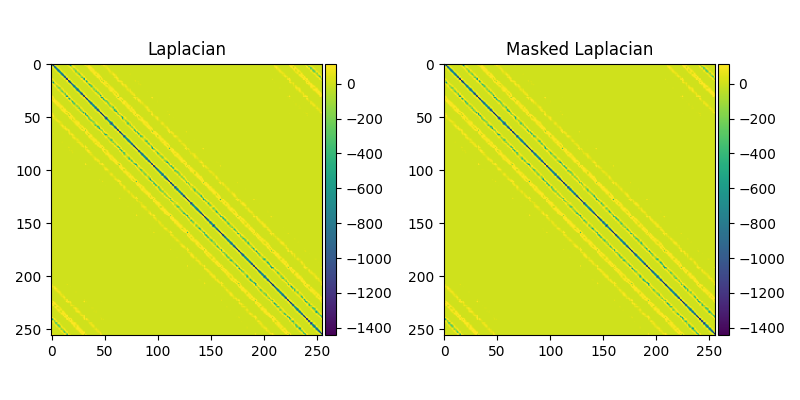

In [385]:
H, L = Hessian(x_ij, r_ij, q_ij, h, k)

print(L.sum(-1), (H[:,:,0,0] + H[:,:,1,1]).sum(-1))

fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
imPlot(fig, axis[0,0], L, 'Laplacian')
imPlot(fig, axis[0,1], torch.where(q_ij <= 1, L, 0), 'Masked Laplacian')

# imPlot(fig, axis[0,1], (H[:,:,0,0] + H[:,:,1,1]), 'Sum of Hessian')

fig.tight_layout()

In [386]:
omegaMatrix = torch.ones(p.shape[0], p.shape[0]) * volume / rho[None,:] # np.arange(1, p.shape[0] + 1)[None,:]
print(omegaMatrix)

tensor([[0.0152, 0.0153, 0.0159,  ..., 0.0161, 0.0154, 0.0148],
        [0.0152, 0.0153, 0.0159,  ..., 0.0161, 0.0154, 0.0148],
        [0.0152, 0.0153, 0.0159,  ..., 0.0161, 0.0154, 0.0148],
        ...,
        [0.0152, 0.0153, 0.0159,  ..., 0.0161, 0.0154, 0.0148],
        [0.0152, 0.0153, 0.0159,  ..., 0.0161, 0.0154, 0.0148],
        [0.0152, 0.0153, 0.0159,  ..., 0.0161, 0.0154, 0.0148]])


torch.Size([256, 256]) torch.Size([256, 256]) torch.Size([256, 256, 2]) torch.Size([256, 256]) torch.Size([256, 256])
torch.Size([256, 256, 2]) torch.Size([256, 256, 2, 2])


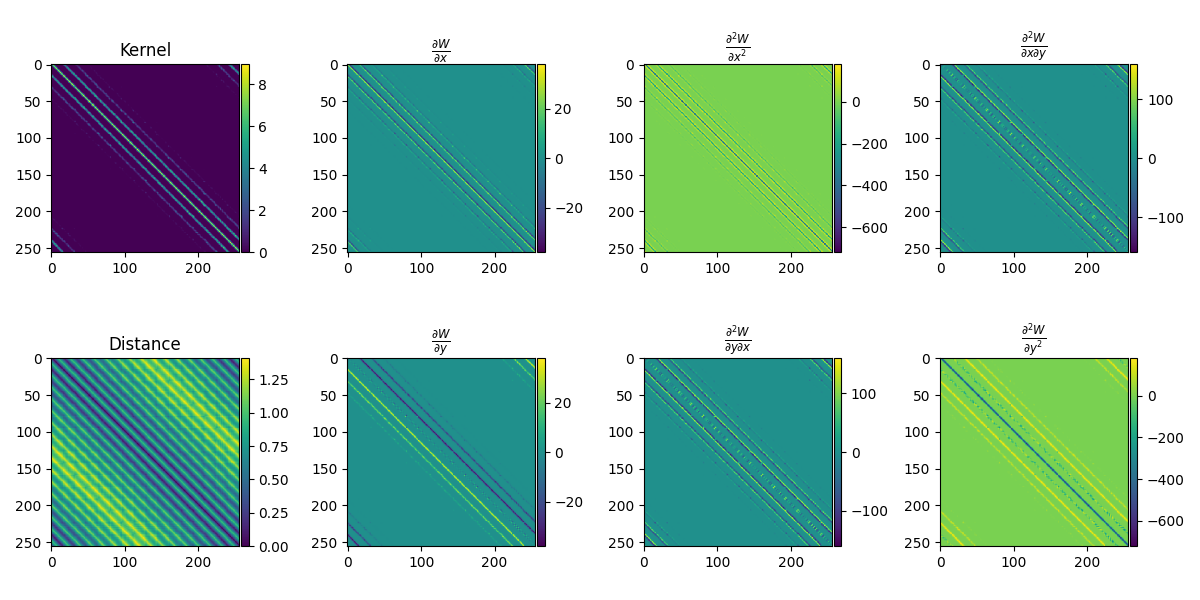

In [387]:
fig, axis = plt.subplots(2, 4, figsize=(12,6), sharex = False, sharey = False, squeeze = False)


kernel = k.kernel(q_ij, supportMatrix, dim = dim)
J = Jacobian(x_ij, r_ij, q_ij, supportMatrix, k)
H, L = Hessian(x_ij, r_ij, q_ij, supportMatrix, k)

print(kernel.shape, q_ij.shape, x_ij.shape, r_ij.shape, supportMatrix.shape)
print(J.shape, H.shape)

imPlot(fig, axis[0,0], kernel, 'Kernel')
imPlot(fig, axis[1,0], r_ij, 'Distance')
imPlot(fig, axis[0,1], J[:,:,0], '$\\frac{\\partial W}{\\partial x}$')
imPlot(fig, axis[1,1], J[:,:,1], '$\\frac{\\partial W}{\\partial y}$')
imPlot(fig, axis[0,2], H[:,:,0,0], '$\\frac{\\partial^2 W}{\\partial x^2}$')
imPlot(fig, axis[1,3], H[:,:,1,1], '$\\frac{\\partial^2 W}{\\partial y^2}$')
imPlot(fig, axis[0,3], H[:,:,0,1], '$\\frac{\\partial^2 W}{\\partial x \\partial y}$')
imPlot(fig, axis[1,2], H[:,:,1,0], '$\\frac{\\partial^2 W}{\\partial y \\partial x}$')

fig.tight_layout()

In [388]:
def evalKernel(p, h, k, dim, domainMin, domainMax, periodic = False):
    i, j, rij, xij, hij, Wij, gradWij = neighborSearch(p, p, h, h, kernel = k, dim = dim, periodic = periodic, minDomain = domainMin, maxDomain = domainMax)
    rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')
    pos = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
    x_ij = pos[:,None] - pos[None,:]
    x_ij[:,:,0] = x_ij[:,:,0] if not periodic else mod(x_ij[:,:,0], domainMin[0], domainMax[0])
    x_ij[:,:,1] = x_ij[:,:,1] if not periodic else mod(x_ij[:,:,1], domainMin[1], domainMax[1])

    r_ij = torch.norm(x_ij, dim = -1)
    q_ij = torch.where(r_ij < h, r_ij, h) /h

    supportMatrix = p.new_ones(p.shape[0], p.shape[0]) * h
    denseKernel = p.new_zeros(p.shape[0], p.shape[0])
    omega = p.new_ones(p.shape[0]) * volume / 1
    K = k.kernel(q_ij, supportMatrix, dim = dim) * omega[None,:]

    J = Jacobian(x_ij, r_ij, q_ij, supportMatrix, k) * omega[None,:,None]
    H,L = Hessian(x_ij, r_ij, q_ij, supportMatrix, k) 

    return rho, K, J, H* omega[None,:,None,None], L


In [389]:
torch.norm(torch.tensor([1,1], dtype = torch.float32))

tensor(1.4142)

In [390]:
p = torch.clone(pInitial) #
i, j, rij, xij, hij, Wij, gradWij = neighborSearch(p, p, h, h, kernel = k, dim = dim, periodic = periodic, minDomain = domainMin, maxDomain = domainMax)
rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')

pos = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
x_ij = pos[:,None] - pos[None,:]
x_ij[:,:,0] = x_ij[:,:,0] if not periodic else mod(x_ij[:,:,0], domainMin[0], domainMax[0])
x_ij[:,:,1] = x_ij[:,:,1] if not periodic else mod(x_ij[:,:,1], domainMin[1], domainMax[1])

r_ij = torch.norm(x_ij, dim = -1)
q_ij = torch.where(r_ij < h, r_ij, h) /h

supportMatrix = p.new_ones(p.shape[0], p.shape[0]) * h
denseKernel = p.new_zeros(p.shape[0], p.shape[0])
omega = p.new_ones(p.shape[0]) * volume / 1
K = k.kernel(q_ij, supportMatrix, dim = dim) * omega[None,:]

In [391]:
hij.shape

torch.Size([11520])

In [392]:
laplacian = sphOperation((areas, areas), (rho, rho), (ones, ones), (i, j), Wij, gradWij, rij, xij, hij, p.shape[0], operation = 'directLaplacian', gradientMode = 'symmetric')

# print(laplacian)

print(L.sum(-1))

tensor([ -127.6898,  -594.2446,  -507.7926,   183.4613,   -11.1043,  -237.4340,
         -789.5012,  -951.7660,  -269.2303,  -107.2734,  -218.5912,   -30.0376,
         -126.1994,  -322.9935, -1070.1775, -1108.3665,  -289.6561,  -857.3637,
         -721.0988,   347.7812,  -219.1529,  -582.2759,  -476.6873,  -155.0837,
         -265.0006,  -360.2706,  -296.9615,  -366.5876,  -649.9869,  -604.9771,
         -707.5488,  -862.2908,  -575.1918,  -759.4678,  -601.1846,  -447.6947,
         -757.4098,  -874.6339,  -601.0318,   -13.6840,  -412.3560,  -738.4862,
         -526.9049, -1023.0143, -1272.1415,  -759.3990,  -377.8795,  -490.0392,
         -338.9614,  -315.7274,  -578.6521, -1471.1151, -1380.9518,  -635.8540,
           41.1219,  -488.4097, -1404.1257, -1296.9492,  -431.1474,  -732.6242,
         -791.6907,  -425.5433,  -192.6568,  -525.6482,  -309.7594,   -26.0178,
         -342.8580, -1062.0726,  -922.4254,  -766.8723,   408.0909,   138.0248,
        -1135.4586, -1011.7109,  -123.95

In [393]:
rho, K, J, H, L = evalKernel(p, h, k, dim, domainMin, domainMax, periodic = True)



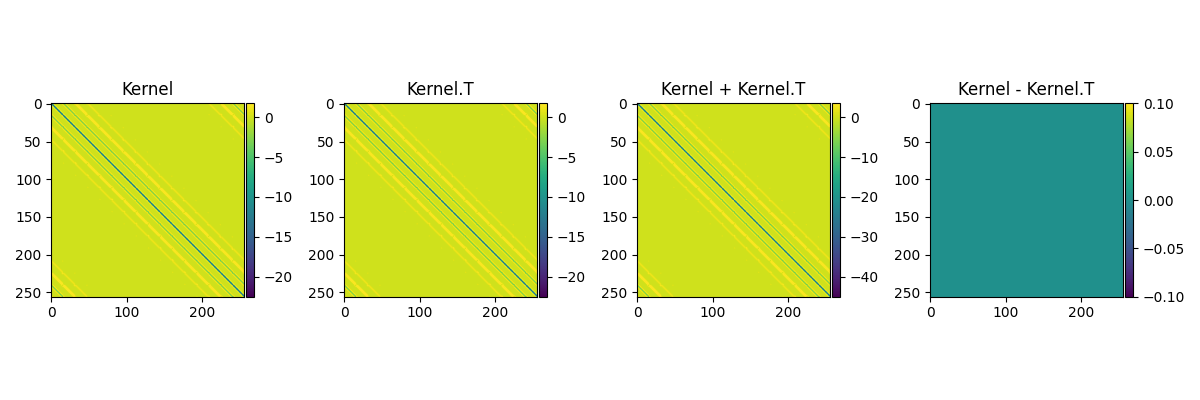

In [394]:
fig, axis = plt.subplots(1, 4, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
K = x_ij[:,:,0]
K = x_ij[:,:,1]
K = k.kernel(q_ij, supportMatrix, dim = dim) * omega[None,:]

K = J[:,:,0] #anti
K = J[:,:,1] #anti
#symmetric
K = H[:,:,0,1] #* omega[None,:]
K = H[:,:,1,0] #* omega[None,:]
K = H[:,:,0,0]
K = H[:,:,1,1] + H[:,:,0,0]
# K = L

imPlot(fig, axis[0,0], K, 'Kernel')
imPlot(fig, axis[0,1], K.T, 'Kernel.T')
imPlot(fig, axis[0,2], K + K.T, 'Kernel + Kernel.T')
imPlot(fig, axis[0,3], K - K.T, 'Kernel - Kernel.T')

fig.tight_layout()

In [395]:
# def LinearCG(A, b, x0, tol=1e-5):
#     xk = x0
#     rk = torch.zeros(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])

#     rk[::2]  += scatter(H[:,0,0] * xk[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
#     rk[::2]  += scatter(H[:,0,1] * xk[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")

#     rk[1::2] += scatter(H[:,1,0] * xk[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
#     rk[1::2] += scatter(H[:,1,1] * xk[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")
    
# #     rk = np.dot(A, xk) - b
#     pk = -rk
#     rk_norm = torch.linalg.norm(rk)
    
#     num_iter = 0
# #     curve_x = [xk]
#     while rk_norm > tol:
#         apk = torch.zeros(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])

#         apk[::2]  += scatter(H[:,0,0] * pk[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
#         apk[::2]  += scatter(H[:,0,1] * pk[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")

#         apk[1::2] += scatter(H[:,1,0] * pk[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
#         apk[1::2] += scatter(H[:,1,1] * pk[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")
# #         apk = np.dot(A, pk)
#         rkrk = torch.dot(rk, rk)
        
#         alpha = rkrk / torch.dot(pk, apk)
#         xk = xk + alpha * pk
#         rk = rk + alpha * apk
#         beta = torch.dot(rk, rk) / rkrk
#         pk = -rk + beta * pk
        
#         num_iter += 1
# #         curve_x.append(xk)
#         rk_norm = torch.linalg.norm(rk)
# #         print('Iteration: {} \t x = {} \t residual = {:.4f}'.
# #               format(num_iter, xk, rk_norm))
    
# #     print('\nSolution: \t x = {}'.format(xk))
        
#     return xk

In [396]:
ni

tensor([48, 49, 50, 49, 52, 48, 50, 50, 47, 50, 50, 50, 48, 51, 49, 50, 51, 49,
        51, 51, 50, 49, 46, 47, 46, 52, 48, 50, 48, 50, 53, 49, 51, 50, 50, 51,
        48, 49, 46, 50, 50, 54, 48, 50, 51, 51, 52, 54, 52, 49, 49, 46, 46, 49,
        50, 50, 51, 49, 46, 50, 51, 50, 48, 50, 47, 48, 49, 50, 48, 49, 51, 51,
        50, 46, 48, 50, 50, 50, 51, 48, 49, 45, 49, 50, 49, 49, 50, 45, 50, 49,
        51, 48, 52, 49, 49, 48, 49, 48, 50, 47, 47, 46, 48, 48, 48, 48, 50, 48,
        51, 48, 51, 50, 47, 45, 49, 52, 47, 45, 49, 50, 49, 51, 50, 48, 47, 48,
        48, 48, 51, 49, 49, 53, 48, 49, 49, 50, 50, 52, 50, 48, 50, 50, 48, 47,
        48, 46, 46, 48, 47, 50, 48, 51, 49, 50, 50, 46, 50, 49, 49, 48, 47, 51,
        51, 49, 49, 47, 49, 51, 49, 50, 48, 50, 47, 47, 49, 49, 49, 52, 48, 51,
        45, 46, 48, 50, 50, 48, 51, 51, 49, 51, 51, 51, 52, 50, 50, 52, 52, 53,
        51, 49, 51, 50, 48, 50, 51, 49, 49, 49, 49, 49, 50, 51, 50, 48, 52, 50,
        52, 51, 48, 50, 50, 50, 48, 50, 

In [397]:
from diffSPH.v2.math import scatter_sum
import scipy

In [19]:
def evalKernel(p, h, k, dim, domainMin, domainMax, periodic = False):
    i, j, rij, xij, hij, Wij, gradWij = neighborSearch(p, p, h, h, kernel = k, dim = dim, periodic = periodic, minDomain = domainMin, maxDomain = domainMax)
    rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')
    pos = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
    
    x_ij = pos[:,None] - pos[None,:]
    x_ij = pos[None,:] - pos[:,None]
    x_ij[:,:,0] = x_ij[:,:,0] if not periodic else mod(x_ij[:,:,0], domainMin[0], domainMax[0])
    x_ij[:,:,1] = x_ij[:,:,1] if not periodic else mod(x_ij[:,:,1], domainMin[1], domainMax[1])

    r_ij = torch.norm(x_ij, dim = -1)
    q_ij = torch.where(r_ij < h, r_ij, h) /h

    supportMatrix = p.new_ones(p.shape[0], p.shape[0]) * h
    denseKernel = p.new_zeros(p.shape[0], p.shape[0])
    omega = p.new_ones(p.shape[0]) * volume / rho
    # omega = torch.arange(1, p.shape[0] + 1)
    K = k.kernel(q_ij, supportMatrix, dim = dim)
    # K[:,:] = 1
    # print(K)
    K = K * omega[None,:]
    # print(K)
    # print(K.sum(0), K.sum(1))

    J = Jacobian(x_ij, r_ij, q_ij, supportMatrix, k) * omega[None,:,None]
    H,L = Hessian(x_ij, r_ij, q_ij, supportMatrix, k) 

    K[q_ij >= 1] = 0
    J[q_ij >= 1,:] = 0
    H[q_ij >= 1,:,:] = 0
    L[q_ij >= 1] = 0

    return rho, K, J, H* omega[None,:,None,None], L

def evalKernel(p, h, k, dim, domainMin, domainMax, periodic = False):
    i, j, rij, xij, hij, Wij, gradWij = neighborSearch(p, p, h, h, kernel = k, dim = dim, periodic = periodic, minDomain = domainMin, maxDomain = domainMax)
    rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, p.shape[0], operation = 'interpolate')
    pos = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
    x_ij = pos[:,None] - pos[None,:]
    x_ij[:,:,0] = x_ij[:,:,0] if not periodic else mod(x_ij[:,:,0], domainMin[0], domainMax[0])
    x_ij[:,:,1] = x_ij[:,:,1] if not periodic else mod(x_ij[:,:,1], domainMin[1], domainMax[1])

    r_ij = torch.norm(x_ij, dim = -1)
    q_ij = torch.where(r_ij < h, r_ij, h) /h

    supportMatrix = p.new_ones(p.shape[0], p.shape[0]) * h
    denseKernel = p.new_zeros(p.shape[0], p.shape[0])
    omega = p.new_ones(p.shape[0]) * volume / 1
    K = k.kernel(q_ij, supportMatrix, dim = dim) * omega[None,:]

    # J = Jacobian(x_ij, r_ij, q_ij, supportMatrix, k) * omega[None,:,None]
    J = k.Jacobi(r_ij.flatten(0,1) / h, (x_ij.flatten(0,1) / (r_ij.flatten(0,1) + 1e-5 * h).view(-1,1)), supportMatrix.flatten()).reshape(p.shape[0], p.shape[0], 2) * omega[None,:,None]
    H = k.Hessian2D(r_ij.flatten(0,1) / h, (x_ij.flatten(0,1) / (r_ij.flatten(0,1) + 1e-5 * h).view(-1,1)), h, dim = 2).reshape(p.shape[0], p.shape[0], 2, 2)
    # H,L = Hessian(x_ij, r_ij, q_ij, supportMatrix, k) 

    return rho, K, J, H* omega[None,:,None,None], None


Iteration 0 	 Residual 4.424948215484619
tensor(2.0717) tensor(-2.2273)
Iteration 1 	 Residual 2.926393508911133
tensor(0.9362) tensor(-0.8911)
Iteration 2 	 Residual 2.0800108909606934
tensor(0.0661) tensor(-0.1045)
Iteration 3 	 Residual 0.37652966380119324
tensor(0.0321) tensor(-0.0249)
Iteration 4 	 Residual 0.08007032424211502
tensor(0.0084) tensor(-0.0103)
Iteration 5 	 Residual 0.033680208027362823
tensor(0.0065) tensor(-0.0067)
Iteration 6 	 Residual 0.025592494755983353
tensor(0.0053) tensor(-0.0060)
Iteration 7 	 Residual 0.022656241431832314
tensor(0.0043) tensor(-0.0057)
Iteration 8 	 Residual 0.020745601505041122
tensor(0.0036) tensor(-0.0053)
Iteration 9 	 Residual 0.018781982362270355
tensor(0.0038) tensor(-0.0049)
Iteration 10 	 Residual 0.016506511718034744
tensor(0.0037) tensor(-0.0043)
Iteration 11 	 Residual 0.014027492143213749
tensor(0.0035) tensor(-0.0037)
Iteration 12 	 Residual 0.01169625110924244
tensor(0.0033) tensor(-0.0031)
Iteration 13 	 Residual 0.0112344

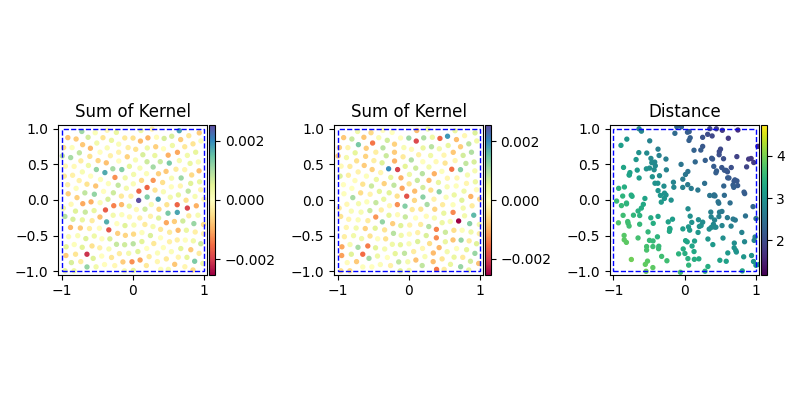

In [20]:
p = torch.clone(pInitial) + torch.normal(0, 0.5 * h, pInitial.shape)
p2 = torch.clone(p)
fig, axis = plt.subplots(1, 3, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
for i in range(16):
    rho, K, J, H, L = evalKernel(p, h, k, dim, domainMin, domainMax, periodic = True)
    numParticles = p.shape[0]
    JJ = J.sum(0)

    print(f'Iteration {i} \t Residual {JJ.abs().max()}')

    B = torch.zeros(JJ.shape[0]*2, device = JJ.device, dtype=JJ.dtype)
    B[::2] = JJ[:,0]
    B[1::2] = JJ[:,1]


    A = torch.zeros(numParticles * 2, numParticles*2, device = K.device, dtype = K.dtype)

    A[::2, ::2] = H[:,:,0,0]
    A[1::2, ::2] = H[:,:,1,0]
    A[::2, 1::2] = H[:,:,0,1]
    A[1::2, 1::2] = H[:,:,1,1]

    diff = torch.linalg.solve(A,B)
    # diff = torch.tensor(scipy.linalg.solve(A.cpu().numpy(), B.cpu().numpy()))

    dx = torch.zeros(J.shape[0], device = J.device, dtype=J.dtype)
    dy = torch.zeros(J.shape[0], device = J.device, dtype=J.dtype)
    dx = -diff[::2]
    dy = -diff[1::2]
    update = torch.vstack((dx,dy)).T 
    print(update.max(), update.min())
    # print(update)
    p = p + update

# update = torch.vstack((dx,dy)).T
# syncQuantity(update, config, state)
# print(diff)

def scatterPlotSymmetric(fig, axis, p, c, domainMin, domainMax, label = None):
    pos_x = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
    # pos_y = torch.stack([y[:,i] if not periodic_i else torch.remainder(y[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

    sc = axis.scatter(pos_x[:,0], pos_x[:,1], s = 8, c = c, vmin = -c.abs().max(), vmax = c.abs().max(), cmap = 'Spectral')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    if p.shape[1] > 1:
        square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        axis.add_patch(square)
    axis.set_aspect('equal')
    axis.set_xlim(-1.05,1.05)
    axis.set_ylim(-1.05,1.05)

scatterPlotSymmetric(fig, axis[0,0], p, dx, domainMin, domainMax, 'Sum of Kernel')
scatterPlotSymmetric(fig, axis[0,1], p, dy, domainMin, domainMax, 'Sum of Kernel')
scatterPlot(fig, axis[0,2], p2, torch.linalg.norm(p2-2, dim = -1), domainMin, domainMax, 'Distance')
fig.tight_layout()

In [40]:
J - J.transpose(0,1)

tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 1.7909e+00, -2.0489e-05],
         [ 7.2912e-01, -3.8767e-05],
         ...,
         [-1.9294e-02, -6.4320e-03],
         [-4.2047e-01, -2.1024e-01],
         [-1.0466e+00, -1.0468e+00]],

        [[-1.7909e+00,  2.0489e-05],
         [ 0.0000e+00,  0.0000e+00],
         [ 1.7911e+00, -1.7002e-04],
         ...,
         [-0.0000e+00, -0.0000e+00],
         [-1.9213e-02, -6.4040e-03],
         [-4.2044e-01, -2.1020e-01]],

        [[-7.2912e-01,  3.8767e-05],
         [-1.7911e+00,  1.7002e-04],
         [ 0.0000e+00,  0.0000e+00],
         ...,
         [-0.0000e+00, -0.0000e+00],
         [-0.0000e+00, -0.0000e+00],
         [-1.9282e-02, -6.4272e-03]],

        ...,

        [[ 1.9294e-02,  6.4320e-03],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00],
         [ 1.7911e+00, -1.3671e-04],
         [ 7.2930e-01,  3.1302e-06]],

        [[ 4.2047e-01,  2.1024e-01

In [41]:
denseKernel.sum(-1)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

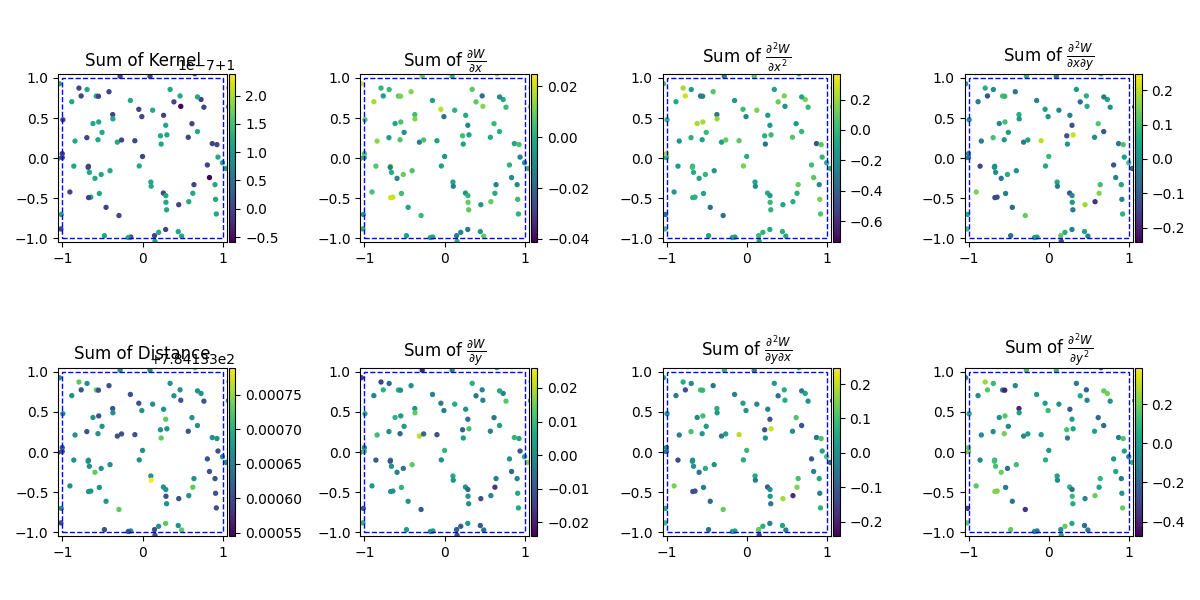

In [348]:
fig, axis = plt.subplots(2, 4, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], p, (omegaMatrix * kernel).sum(-1), domainMin, domainMax, 'Sum of Kernel')
scatterPlot(fig, axis[1,0], p, r_ij.sum(-1), domainMin, domainMax, 'Sum of Distance')
scatterPlot(fig, axis[0,1], p, (omegaMatrix * J[:,:,0]).sum(-1), domainMin, domainMax, 'Sum of $\\frac{\\partial W}{\\partial x}$')
scatterPlot(fig, axis[1,1], p, (omegaMatrix * J[:,:,1]).sum(-1), domainMin, domainMax, 'Sum of $\\frac{\\partial W}{\\partial y}$')
scatterPlot(fig, axis[0,2], p, (omegaMatrix * H[:,:,0,0]).sum(-1), domainMin, domainMax, 'Sum of $\\frac{\\partial^2 W}{\\partial x^2}$')
scatterPlot(fig, axis[1,3], p, (omegaMatrix * H[:,:,1,1]).sum(-1), domainMin, domainMax, 'Sum of $\\frac{\\partial^2 W}{\\partial y^2}$')
scatterPlot(fig, axis[0,3], p, (omegaMatrix * H[:,:,0,1]).sum(-1), domainMin, domainMax, 'Sum of $\\frac{\\partial^2 W}{\\partial x \\partial y}$')
scatterPlot(fig, axis[1,2], p, (omegaMatrix * H[:,:,1,0]).sum(-1), domainMin, domainMax, 'Sum of $\\frac{\\partial^2 W}{\\partial y \\partial x}$')

fig.tight_layout()

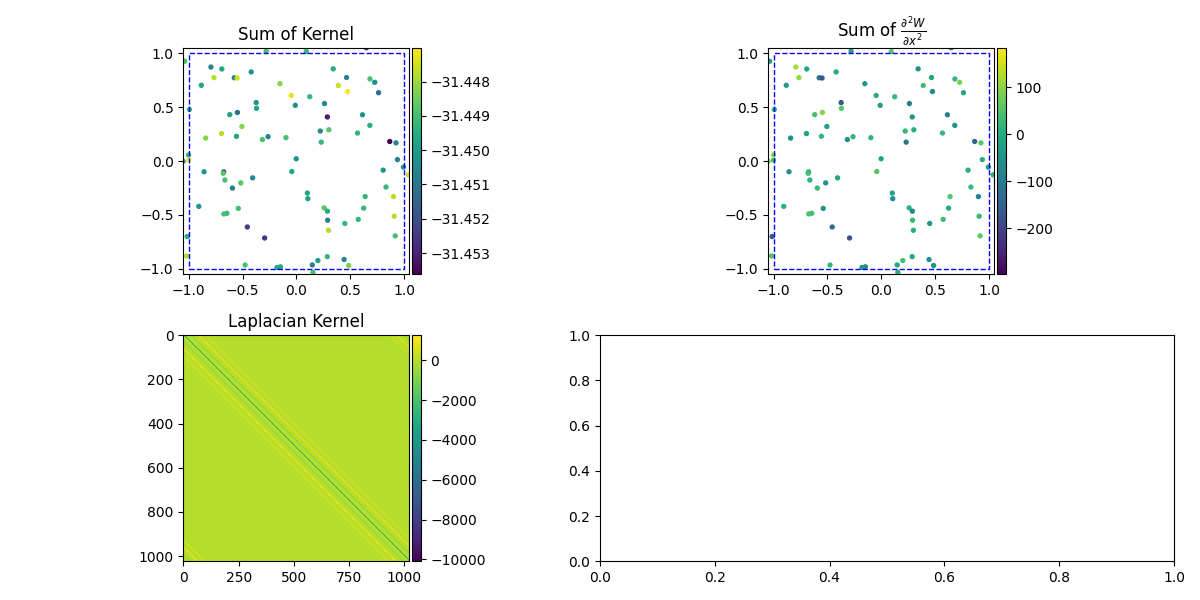

In [349]:
k2 = k.kernelLaplacian(q_ij, supportMatrix, dim = dim)
fig, axis = plt.subplots(2, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], p, k2.sum(-1), domainMin, domainMax, 'Sum of Kernel')
imPlot(fig, axis[1,0], k2, 'Laplacian Kernel')


scatterPlot(fig, axis[0,1], p, (H[:,:,0,0]+ H[:,:,1,1]).sum(-1), domainMin, domainMax, 'Sum of $\\frac{\\partial^2 W}{\\partial x^2}$')

fig.tight_layout()